## FeatureEngineering_WNV

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import geopandas as gpd

import plotly.express as px
import plotly.graph_objects as go

sns.set()

## Load Data

In [2]:
# The supplied CSV data file is the DataSet directory
merged_df = pd.read_csv('../clean_data/merged_df.csv')
spray_df = pd.read_csv('../data/spray.csv')
train_df = pd.read_csv('../clean_data/train_df.csv')
test = pd.read_csv('../data/test.csv')

In [3]:
train_df = []
test_df =[]
test_df = test.copy()
train_df = merged_df.copy()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 47 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              10506 non-null  int64  
 1   Date                    10506 non-null  object 
 2   Address                 10506 non-null  object 
 3   Species                 10506 non-null  object 
 4   Block                   10506 non-null  float64
 5   Street                  10506 non-null  object 
 6   Trap                    10506 non-null  object 
 7   AddressNumberAndStreet  10506 non-null  object 
 8   Latitude                10506 non-null  float64
 9   Longitude               10506 non-null  float64
 10  AddressAccuracy         10506 non-null  float64
 11  NumMosquitos            10506 non-null  float64
 12  WnvPresent              10506 non-null  float64
 13  Dist_St1                10506 non-null  float64
 14  Dist_St2                10506 non-null

### Create new features [Weekly avg Temp and Weely total Precip]

In [4]:
# Since temperature and preciptation are the most likely precursor for mosquitos and eventally the virus 
# lets work with those variable.

# First thing is lets craete two more columns with average weekly average tempearture and weekly precipitation
merged_df['Tavg_weekly'] = merged_df['Tavg'].groupby(merged_df['yearweek']).transform('mean')
print(merged_df['Tavg_weekly'].isnull().sum())

merged_df['PrecipTotal_Weekly'] = merged_df['PrecipTotal'].groupby(merged_df['yearweek']).transform('sum')
print(merged_df['PrecipTotal_Weekly'].isnull().sum())
merged_df.head()

0
0


,Unnamed: 0,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,...,Tvaglag1,Tvaglag2,Tvaglag3,Tvaglag4,PTotallag1,PTotallag2,PTotallag3,PTotallag4,Tavg_weekly,PrecipTotal_Weekly
0,0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41.0,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,...,65.0,66.0,71.0,69.0,0.001,0.04,0.0,0.38,76.16,0.0
1,1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41.0,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,...,65.0,66.0,71.0,69.0,0.001,0.04,0.0,0.38,76.16,0.0
2,2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62.0,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,...,65.0,66.0,71.0,69.0,0.001,0.04,0.0,0.38,76.16,0.0
3,3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79.0,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,...,65.0,66.0,71.0,69.0,0.001,0.04,0.0,0.38,76.16,0.0
4,4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79.0,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,...,65.0,66.0,71.0,69.0,0.001,0.04,0.0,0.38,76.16,0.0


### Lets create some time lag variables on weather data

In [5]:
# Borowed this from someone lese project found online. Was struggling with the execution
def create_lagdata(df, var, label):
    YearWeek = df['yearweek'][0]
    
    for i in range(8):
        try:
            df[f'{label}{i+1}'] = df[df['yearweek'] == (YearWeek - (i+1))][var].unique()[0]
            
        # For the first 4 weeks of the year where no previous data exists, create rough estimate of temperatures
        except IndexError:
            df[f'{label}{i+1}'] = df[var] - i
    return df
    

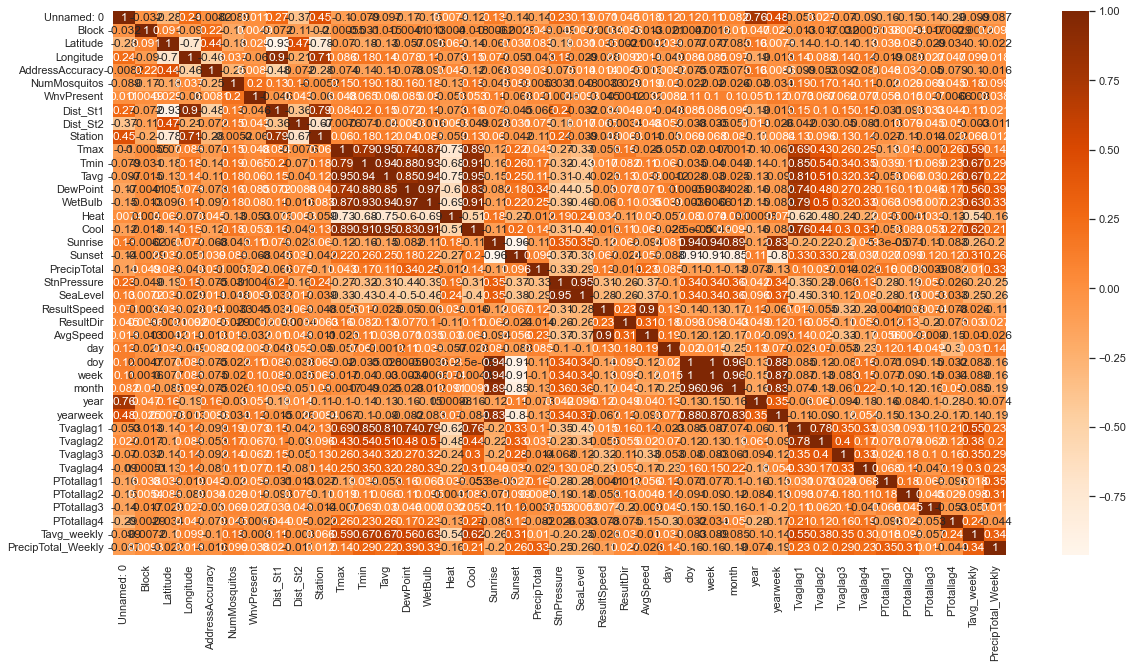

In [6]:
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(merged_df.corr(), annot=True, cmap="Oranges" ,ax = ax)
plt.show()

In [7]:
merged_df.corr()['WnvPresent'].sort_values(ascending = False)

WnvPresent            1.000000
NumMosquitos          0.196820
yearweek              0.123809
doy                   0.105767
Sunrise               0.105227
week                  0.104171
month                 0.100143
DewPoint              0.084904
WetBulb               0.079594
Tvaglag4              0.076788
Tvaglag1              0.073202
Tvaglag2              0.066628
Tmin                  0.065182
Tvaglag3              0.062197
Tavg                  0.059881
PTotallag1            0.058148
Cool                  0.052920
year                  0.050865
Tmax                  0.047580
Dist_St2              0.043484
PrecipTotal_Weekly    0.037908
Latitude              0.028697
PTotallag3            0.026817
PrecipTotal           0.021307
PTotallag2            0.015459
Unnamed: 0            0.010857
SeaLevel              0.009346
day                   0.008245
AddressAccuracy       0.008064
Block                 0.004877
ResultDir            -0.001229
StnPressure          -0.004591
PTotalla

In [8]:
merged_df.corr()['NumMosquitos'].sort_values(ascending = False)

NumMosquitos          1.000000
WnvPresent            0.196820
Tmin                  0.190109
Tvaglag1              0.188069
Tavg                  0.182138
WetBulb               0.179083
Cool                  0.178402
Tavg_weekly           0.177994
Tvaglag2              0.169082
DewPoint              0.159950
Tmax                  0.153975
Dist_St2              0.153243
Tvaglag3              0.135723
Dist_St1              0.127583
Tvaglag4              0.113341
PrecipTotal_Weekly    0.099040
Sunset                0.088884
PTotallag3            0.069145
PTotallag4            0.044914
Longitude             0.036633
PTotallag2            0.028598
day                   0.020451
AvgSpeed              0.019458
ResultSpeed          -0.003319
Station              -0.005176
PrecipTotal          -0.005278
PTotallag1           -0.019720
week                 -0.020444
doy                  -0.021949
month                -0.026040
ResultDir            -0.029374
year                 -0.029611
StnPress

In [9]:
## Check for multicollineariaty
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [10]:
#X_variables  =merged_df.columns.tolist()
X_variables = merged_df[['Latitude',
 'Longitude',
 'AddressAccuracy',
 'NumMosquitos',
 'WnvPresent',
 'Dist_St1',
 'Dist_St2',
 'Station',
 'Tmax',
 'Tmin',
 'Tavg',
 'DewPoint',
 'WetBulb',
 'Heat',
 'Cool',
 'Sunrise',
 'Sunset',
 'PrecipTotal',
 'StnPressure',
 'SeaLevel',
 'ResultSpeed',
 'ResultDir',
 'AvgSpeed',
 'Tvaglag1',
 'Tvaglag2',
 'Tvaglag3',
 'Tvaglag4',
 'PTotallag1',
 'PTotallag2',
 'PTotallag3',
 'PTotallag4']]

In [11]:
X_variables

,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Dist_St1,Dist_St2,Station,Tmax,Tmin,...,ResultDir,AvgSpeed,Tvaglag1,Tvaglag2,Tvaglag3,Tvaglag4,PTotallag1,PTotallag2,PTotallag3,PTotallag4
0,41.954690,-87.800991,9.0,1.0,0.0,11.7974,19.1911,1,88,60,...,18,6.5,65.0,66.0,71.0,69.0,0.001,0.04,0.000,0.38
1,41.954690,-87.800991,9.0,1.0,0.0,11.7974,19.1911,1,88,60,...,18,6.5,65.0,66.0,71.0,69.0,0.001,0.04,0.000,0.38
2,41.994991,-87.769279,9.0,1.0,0.0,13.5300,23.2827,1,88,60,...,18,6.5,65.0,66.0,71.0,69.0,0.001,0.04,0.000,0.38
3,41.974089,-87.824812,8.0,1.0,0.0,9.2395,21.7659,1,88,60,...,18,6.5,65.0,66.0,71.0,69.0,0.001,0.04,0.000,0.38
4,41.974089,-87.824812,8.0,4.0,0.0,9.2395,21.7659,1,88,60,...,18,6.5,65.0,66.0,71.0,69.0,0.001,0.04,0.000,0.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10501,41.904194,-87.756155,9.0,13.0,0.0,17.7720,13.1471,2,75,55,...,9,4.6,64.0,71.5,77.0,73.0,0.000,0.00,0.001,0.06
10502,41.904194,-87.756155,9.0,5.0,0.0,17.7720,13.1471,2,75,55,...,9,4.6,64.0,71.5,77.0,73.0,0.000,0.00,0.001,0.06
10503,41.763733,-87.742302,8.0,6.0,1.0,30.1754,2.6033,2,75,55,...,9,4.6,64.0,71.5,77.0,73.0,0.000,0.00,0.001,0.06
10504,41.912563,-87.668055,9.0,1.0,0.0,23.7496,15.6971,2,75,55,...,9,4.6,64.0,71.5,77.0,73.0,0.000,0.00,0.001,0.06


In [12]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_variables.columns
vif_data["VIF"] = [variance_inflation_factor(X_variables.values, i) for i in range(len(X_variables.columns))]

In [13]:
vif_data[vif_data['VIF']<=15]

,feature,VIF
2,AddressAccuracy,1.527703
3,NumMosquitos,1.313600
4,WnvPresent,1.084108
6,Dist_St2,2.823708
7,Station,12.440821
17,PrecipTotal,1.561205
20,ResultSpeed,7.869592
21,ResultDir,1.430716
22,AvgSpeed,8.902392
23,Tvaglag1,10.013411


In [14]:
relevant_features = vif_data.feature[vif_data['VIF']<=15].tolist()
relevant_features

['AddressAccuracy',
 'NumMosquitos',
 'WnvPresent',
 'Dist_St2',
 'Station',
 'PrecipTotal',
 'ResultSpeed',
 'ResultDir',
 'AvgSpeed',
 'Tvaglag1',
 'Tvaglag2',
 'Tvaglag3',
 'Tvaglag4',
 'PTotallag1',
 'PTotallag2',
 'PTotallag3',
 'PTotallag4']

In [15]:
## Check the distribution of target variable

In [16]:
merged_df['WnvPresent'].value_counts(normalize = True)

0.0    0.947554
1.0    0.052446
Name: WnvPresent, dtype: float64

In [17]:
merged_df['WnvPresent'].value_counts()

0.0    9955
1.0     551
Name: WnvPresent, dtype: int64

In [18]:
## Balance the data 

In [19]:
tmp_df = merged_df.groupby(['WnvPresent'])

In [20]:
final_df =pd.DataFrame(tmp_df.apply(lambda x: x.sample(tmp_df.size().min())).reset_index(drop = True))
final_df

,Unnamed: 0,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,...,Tvaglag1,Tvaglag2,Tvaglag3,Tvaglag4,PTotallag1,PTotallag2,PTotallag3,PTotallag4,Tavg_weekly,PrecipTotal_Weekly
0,766,2007-08-01,"7100 South South Shore Drive, Chicago, IL 6064...",CULEX RESTUANS,71.0,S SOUTH SHORE DR,T079,"7100 S SOUTH SHORE DR, Chicago, IL",41.766202,-87.562889,...,79.0,76.0,77.0,77.0,0.000,0.00,0.000,0.92,76.949234,40.749
1,3331,2009-06-29,"South Brandon Avenue, Chicago, IL 60617, USA",CULEX PIPIENS/RESTUANS,13.0,S BRANDON,T209,"1300 S BRANDON, Chicago, IL",41.740641,-87.546587,...,76.0,79.0,80.0,69.0,0.000,0.05,0.060,0.00,69.420912,151.589
2,4280,2009-09-25,"1100 North Artesian Avenue, Chicago, IL 60622,...",CULEX PIPIENS,11.0,S ARTESIAN AVE,T160,"1100 S ARTESIAN AVE, Chicago, IL",41.903002,-87.688267,...,68.0,69.0,66.0,71.0,0.000,0.00,0.000,0.00,68.275362,9.220
3,3215,2009-06-19,"2200 North Cannon Drive, Chicago, IL 60614, USA",CULEX SALINARIUS,22.0,N CANNON DR,T054,"2200 N CANNON DR, Chicago, IL",41.921965,-87.632085,...,72.0,68.0,61.0,64.0,0.110,0.00,0.001,0.00,69.015326,198.190
4,750,2007-08-01,"3900 South Ashland Avenue, Chicago, IL 60609, USA",CULEX RESTUANS,39.0,S ASHLAND AVE,T074,"3900 S ASHLAND AVE, Chicago, IL",41.822536,-87.666343,...,79.0,76.0,77.0,77.0,0.000,0.00,0.000,0.92,76.949234,40.749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1097,6812,2013-08-29,"South Vincennes Avenue, Chicago, IL, USA",CULEX PIPIENS/RESTUANS,10.0,S VINCENNES,T089,"1000 S VINCENNES, Chicago, IL",41.723195,-87.649970,...,77.0,87.0,73.0,66.0,0.000,0.00,0.360,0.00,68.275362,9.220
1098,3131,2013-08-29,"5800 North Ridge Avenue, Chicago, IL 60660, USA",CULEX PIPIENS/RESTUANS,58.0,N RIDGE AVE,T231,"5800 N RIDGE AVE, Chicago, IL",41.987280,-87.666066,...,77.0,87.0,73.0,65.0,0.000,0.00,0.230,0.00,68.275362,9.220
1099,3167,2013-09-06,"ORD Terminal 5, O'Hare International Airport, ...",CULEX PIPIENS/RESTUANS,10.0,W OHARE AIRPORT,T900,"1000 W OHARE AIRPORT, Chicago, IL",41.974689,-87.890615,...,67.0,72.0,82.0,72.0,0.001,0.00,0.360,0.00,62.495268,45.970
1100,1768,2007-08-21,"5200 South Nordica Avenue, Chicago, IL 60638, USA",CULEX PIPIENS/RESTUANS,52.0,S NORDICA,T070,"5200 S NORDICA, Chicago, IL",41.797616,-87.797894,...,72.0,66.0,75.0,83.0,0.480,1.33,0.450,0.06,76.619841,351.837


In [22]:
final_df = final_df[relevant_features]
final_df.to_csv('../clean_data/final_df.csv',index=False)